In [246]:
%matplotlib inline

# Transition Matrix Part 2

In [181]:
import pandas as pd

In [182]:
import matplotlib.pyplot as plt

In [183]:
df_merged = pd.read_csv('../_data/df_subway_merged.csv')

In [184]:
df_merged['localTimestamp'] = pd.to_datetime(df_merged['localTimestamp'])

In [289]:
df_merged.head()

,venueId,latitude,longitude,localTimestamp,id,line_id,line_name,name,next_0_name,next_0_id,next_1_name,next_1_id,line_color,hour
0,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-04 02:59:52,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,9930316,Itabashi Ward Office,9930318,#0080c6,2
1,4b7481e1f964a520bde02de3,35.730,139.71,2012-04-04 03:52:17,2800609,28006,Tokyo Metro Yurakucho Line,Ikebukuro,Town,2800608,Higashi Ikebukuro,2800610,#bb8b38,3
2,4b7481e1f964a520bde02de3,35.730,139.71,2012-04-04 03:52:17,2800201,28002,Tokyo Metro Marunouchi Line,Ikebukuro,NaN,0,Shin-Otsuka,2800202,#ed1c24,3
3,4b2692f9f964a520be7d24e3,35.689,139.71,2012-04-04 03:56:43,2800216,28002,Tokyo Metro Marunouchi Line,Shinjuku Gyoenmae front,Yotsuya 3-chome,2800215,Shinjuku 3-chome,2800217,#ed1c24,3
4,4b5599caf964a5209be827e3,35.670,139.82,2012-04-04 04:06:34,2800414,28004,Tokyo Metro Tozai Line,Toyocho,Kiba,2800413,Minami-sen,2800415,#00b2dd,4


In [186]:
list_lines = df_merged['line_name'].unique()

In [187]:
list_lines

array(['Toei Mita Line', 'Tokyo Metro Yurakucho Line',
       'Tokyo Metro Marunouchi Line', 'Tokyo Metro Tozai Line',
       'Tokyo Metro Hanzomon Line', 'Toei Shinjuku Line',
       'Tokyo Metro Hibiya Line', 'Tokyo Metro Chiyoda Line',
       'Toei Oedo Line', 'Tokyo Metro Ginza Line', 'Toei Asakusa Line',
       'Tokyo Metro Namboku Line', 'Tokyo Metro Fukutoshin Line'], dtype=object)

In [70]:
def plot_usage_of_checkins_custom(start_date, end_date, df, plot=False):
    """start_date: 'YYYY-MM-DD'"""
    df = df[(df['localTimestamp'] > start_date) & 
                     (df['localTimestamp'] < end_date)]
    # Count check-ins by hour, then group by hour and take mean of this across days
    df = df[['localTimestamp', 'venueId']].groupby(pd.Grouper(key='localTimestamp', freq='1H')).count()
    df['hour'] = df.index.map(lambda x: x.hour)
    df_hr_mean = df.groupby('hour').mean()
    if plot:
        df_hr_mean.plot(kind='bar', title="Check-in Histogram for {} to {}".format(start_date, end_date)).set_ylabel("average check-ins")
    return df_hr_mean

## Algorithm 1: Transition Matrix from Stationary Distributions  

For each line:  
* Group the line data by hour  
* For each hour group:
  * Find the average number of stops per station
      * Use this to inform the probability of moving to whichever of out-nodes

### Example: Toei Mita Line

In [197]:
df_mita = df_merged[df_merged['line_name'] == 'Toei Mita Line']

In [131]:
df_mita['localTimestamp'][0]

Timestamp('2012-04-04 02:59:52')

In [132]:
df_mita['hour'] = df_mita['localTimestamp'].map(lambda x: x.hour)

/Users/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [133]:
df_mita['day'] = df_mita['localTimestamp'].map(lambda x: x.day)

/Users/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


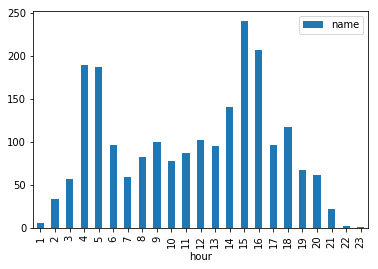

In [134]:
df_mita[['name', 'hour']].groupby('hour').count().plot(kind='bar')

In [91]:
list_mita_hr_blocks = [[1, 2, 3], [4, 5], [6, 7, 8, 9, 10, 11, 12, 13, 14], 
                       [15, 16], [17, 18, 19, 20, 21, 22, 23]]

In [136]:
df_mita[df_mita['hour'] == 1]['name'].value_counts()

Shinbashi    5
Hibiya       1
Name: name, dtype: int64

## Larger Ontology  

d3_json -> (key: hour, value: dict) -> (key: train_line, value: dict) -> {'nodes': [], 'links': []}

In [188]:
df_merged['hour'] = df_merged['localTimestamp'].apply(lambda x: x.hour)

In [320]:
dfs_by_hour = []
train_lines = df_merged['line_name'].unique()
for i in range(0, 24):
    dfs_in_hour_i = {}
    df_in_hour_i = df_merged[df_merged['hour'] == i]
    for l in train_lines:
        try:
            dfs_in_hour_i[l] = df_in_hour_i[df_in_hour_i['line_name'] == l].fillna(value='')
        except:
            print('error')
    dfs_by_hour.append(dfs_in_hour_i)

In [190]:
train_lines

array(['Toei Mita Line', 'Tokyo Metro Yurakucho Line',
       'Tokyo Metro Marunouchi Line', 'Tokyo Metro Tozai Line',
       'Tokyo Metro Hanzomon Line', 'Toei Shinjuku Line',
       'Tokyo Metro Hibiya Line', 'Tokyo Metro Chiyoda Line',
       'Toei Oedo Line', 'Tokyo Metro Ginza Line', 'Toei Asakusa Line',
       'Tokyo Metro Namboku Line', 'Tokyo Metro Fukutoshin Line'], dtype=object)

In [305]:
nodes_JSON['Toei Asakusa Line']

[{'id': 9930218,
  'latitude': 35.709,
  'line_color': '#ef5ba1',
  'longitude': 139.8,
  'name': 'Asakusa'},
 {'id': 9930219,
  'latitude': 35.709,
  'line_color': '#ef5ba1',
  'longitude': 139.8,
  'name': 'Main Office Azumabashi'},
 {'id': 9930207,
  'latitude': 35.639,
  'line_color': '#ef5ba1',
  'longitude': 139.74,
  'name': 'Sengakuji'},
 {'id': 9930214,
  'latitude': 35.686,
  'line_color': '#ef5ba1',
  'longitude': 139.78,
  'name': 'Ningyo-cho'},
 {'id': 9930208,
  'latitude': 35.648,
  'line_color': '#ef5ba1',
  'longitude': 139.75,
  'name': 'Mita'},
 {'id': 9930215,
  'latitude': 35.692,
  'line_color': '#ef5ba1',
  'longitude': 139.78,
  'name': 'East Japan Bridge'},
 {'id': 9930217,
  'latitude': 35.703,
  'line_color': '#ef5ba1',
  'longitude': 139.79,
  'name': 'Kuramae'},
 {'id': 9930209,
  'latitude': 35.657,
  'line_color': '#ef5ba1',
  'longitude': 139.75,
  'name': 'Daimon'},
 {'id': 9930210,
  'latitude': 35.666,
  'line_color': '#ef5ba1',
  'longitude': 139.76,

In [321]:
dfs_by_hour[10]['Toei Asakusa Line']

,venueId,latitude,longitude,localTimestamp,id,line_id,line_name,name,next_0_name,next_0_id,next_1_name,next_1_id,line_color,hour
201,4b29ffe8f964a5209aa424e3,35.639,139.74,2012-04-04 10:06:55,9930207,99302,Toei Asakusa Line,Sengakuji,Takanashi,9930206,Mita,9930208,#ef5ba1,10
818,4b6929a7f964a520ac9a2be3,35.709,139.80,2012-04-08 10:47:14,9930218,99302,Toei Asakusa Line,Asakusa,Kuramae,9930217,Main Office Azumabashi,9930219,#ef5ba1,10
819,4b6929a7f964a520ac9a2be3,35.709,139.80,2012-04-08 10:47:14,9930219,99302,Toei Asakusa Line,Main Office Azumabashi,Asakusa,9930218,Oshigami (before the sky tree),9930220,#ef5ba1,10
1642,4b6929a7f964a520ac9a2be3,35.709,139.80,2012-04-11 10:45:59,9930218,99302,Toei Asakusa Line,Asakusa,Kuramae,9930217,Main Office Azumabashi,9930219,#ef5ba1,10
1643,4b6929a7f964a520ac9a2be3,35.709,139.80,2012-04-11 10:45:59,9930219,99302,Toei Asakusa Line,Main Office Azumabashi,Asakusa,9930218,Oshigami (before the sky tree),9930220,#ef5ba1,10
1999,4b680223f964a520bd632be3,35.648,139.75,2012-04-12 10:16:31,9930208,99302,Toei Asakusa Line,Mita,Sengakuji,9930207,Daimon,9930209,#ef5ba1,10
2002,4b5ee5e8f964a520f89c29e3,35.596,139.71,2012-04-12 10:20:42,9930202,99302,Toei Asakusa Line,Magome,Nishimakome,9930201,Nakanobu,9930203,#ef5ba1,10
2003,4b29ffe8f964a5209aa424e3,35.639,139.74,2012-04-12 10:24:48,9930207,99302,Toei Asakusa Line,Sengakuji,Takanashi,9930206,Mita,9930208,#ef5ba1,10
2007,4b23286ff964a520f65324e3,35.657,139.75,2012-04-12 10:37:44,9930209,99302,Toei Asakusa Line,Daimon,Mita,9930208,Shimbashi,9930210,#ef5ba1,10
2008,4b5ee5e8f964a520f89c29e3,35.596,139.71,2012-04-12 10:40:11,9930202,99302,Toei Asakusa Line,Magome,Nishimakome,9930201,Nakanobu,9930203,#ef5ba1,10


In [315]:
def get_transition_probs(df):
    dict_visited = {}
    count = -1
    for ix, row in df.iterrows():
        count += 1
        next_0_name = row['next_0_name']
        next_1_name = row['next_1_name']
        color = row['line_color']
        name = row['name']
        if name not in dict_visited:
            dict_visited[name] = {'count': 0, next_0_name: 0, next_1_name: 0, 
                                 name: 0, 'color': color}
        else:
            dict_visited[name]['count'] += 1
            df_runner = df[count:]
            add_self = True
            for ix, row in df_runner.iterrows():
                if row['name'] == next_0_name:
                    dict_visited[name][next_0_name] += 1
                    add_self = False
                    break
                elif row['name'] == next_1_name:
                    dict_visited[name][next_1_name] += 1
                    add_self = False
                    break
                else:
                    pass
            if add_self:
                dict_visited[name][name] += 1
    links = []
    for key in dict_visited:
        value = dict_visited[key]
        for k in value:
            if value['count'] > 0:
                if k != 'count' and k != 'color':
                    links.append({'source': key, 'target': k, 
                                  'value': value[k],'total_count': value['count'], 
                                  'color': value['color'] })            
    return links

In [322]:
get_transition_probs(dfs_by_hour[10]['Tokyo Metro Marunouchi Line'])

[{'color': '#ed1c24',
  'source': 'Akasaka Mitsuke',
  'target': 'In front of the National Assembly building',
  'total_count': 19,
  'value': 19},
 {'color': '#ed1c24',
  'source': 'Akasaka Mitsuke',
  'target': 'Yotsuya',
  'total_count': 19,
  'value': 0},
 {'color': '#ed1c24',
  'source': 'Akasaka Mitsuke',
  'target': 'Akasaka Mitsuke',
  'total_count': 19,
  'value': 0},
 {'color': '#ed1c24',
  'source': 'Ginza',
  'target': 'Tokyo',
  'total_count': 27,
  'value': 0},
 {'color': '#ed1c24',
  'source': 'Ginza',
  'target': 'Kasumigaseki',
  'total_count': 27,
  'value': 27},
 {'color': '#ed1c24',
  'source': 'Ginza',
  'target': 'Ginza',
  'total_count': 27,
  'value': 0},
 {'color': '#ed1c24',
  'source': 'Korakuen',
  'target': 'Yodoya',
  'total_count': 1,
  'value': 0},
 {'color': '#ed1c24',
  'source': 'Korakuen',
  'target': 'Hongo 3-chome',
  'total_count': 1,
  'value': 1},
 {'color': '#ed1c24',
  'source': 'Korakuen',
  'target': 'Korakuen',
  'total_count': 1,
  'value'

### Nodes are the same (per line)

In [327]:
nodes_JSON = {}
for line in list_lines:
    nodes_JSON[line] = []
    df = df_merged[df_merged['line_name'] == line]
    station_names = []
    for ix, row in df.iterrows():
        if row['name'] not in station_names:
            nodes_JSON[line].append({'id': row['id'], 'name': row['name'], 
                                     'longitude': row['longitude'], 'latitude': row['latitude'], 
                                     'line_color': row['line_color']})
            station_names.append(row['name'])

In [330]:
nodes_JSON

{'Toei Asakusa Line': [{'id': 9930218,
   'latitude': 35.709,
   'line_color': '#ef5ba1',
   'longitude': 139.8,
   'name': 'Asakusa'},
  {'id': 9930219,
   'latitude': 35.709,
   'line_color': '#ef5ba1',
   'longitude': 139.8,
   'name': 'Main Office Azumabashi'},
  {'id': 9930207,
   'latitude': 35.639,
   'line_color': '#ef5ba1',
   'longitude': 139.74,
   'name': 'Sengakuji'},
  {'id': 9930214,
   'latitude': 35.686,
   'line_color': '#ef5ba1',
   'longitude': 139.78,
   'name': 'Ningyo-cho'},
  {'id': 9930208,
   'latitude': 35.648,
   'line_color': '#ef5ba1',
   'longitude': 139.75,
   'name': 'Mita'},
  {'id': 9930215,
   'latitude': 35.692,
   'line_color': '#ef5ba1',
   'longitude': 139.78,
   'name': 'East Japan Bridge'},
  {'id': 9930217,
   'latitude': 35.703,
   'line_color': '#ef5ba1',
   'longitude': 139.79,
   'name': 'Kuramae'},
  {'id': 9930209,
   'latitude': 35.657,
   'line_color': '#ef5ba1',
   'longitude': 139.75,
   'name': 'Daimon'},
  {'id': 9930210,
   'latit

In [266]:
lines_total = []
for k in nodes_JSON:
    lines_total.extend(nodes_JSON[k])

In [264]:
line_names = []
for k in nodes_JSON:
    line_names.append(k)
line_names = sorted(line_names)
for i in line_names:
    print('<option>{}</option>'.format(i))

<option>Toei Asakusa Line</option>
<option>Toei Mita Line</option>
<option>Toei Oedo Line</option>
<option>Toei Shinjuku Line</option>
<option>Tokyo Metro Chiyoda Line</option>
<option>Tokyo Metro Fukutoshin Line</option>
<option>Tokyo Metro Ginza Line</option>
<option>Tokyo Metro Hanzomon Line</option>
<option>Tokyo Metro Hibiya Line</option>
<option>Tokyo Metro Marunouchi Line</option>
<option>Tokyo Metro Namboku Line</option>
<option>Tokyo Metro Tozai Line</option>
<option>Tokyo Metro Yurakucho Line</option>


## JSON Export

In [232]:
import json

In [242]:
full_data = []
for df_by_hour in dfs_by_hour:
    dict_data = {}
    for line_name in list_lines:
        nodes = nodes_JSON[line_name]
        links = get_transition_probs(df_by_hour[line_name])
        dict_data[line_name] = {'nodes': nodes, 'links': links}
    full_data.append(dict_data)

In [323]:
link_data = []
for df_by_hour in dfs_by_hour:
    dict_data = {}
    for line_name in list_lines:
        links = get_transition_probs(df_by_hour[line_name])
        dict_data[line_name] = links
    link_data.append(dict_data)

In [328]:
nodes_JSON[ 'Tokyo Metro Fukutoshin Line']

[{'id': 2801013,
  'latitude': 35.691,
  'line_color': '#ba6831',
  'longitude': 139.7,
  'name': 'Shinjuku 3-chome'},
 {'id': 2801006,
  'latitude': 35.744,
  'line_color': '#ba6831',
  'longitude': 139.68,
  'name': 'Kotakebara'},
 {'id': 2801015,
  'latitude': 35.668,
  'line_color': '#ba6831',
  'longitude': 139.71,
  'name': 'Meiji Jingumae <Harajuku>'},
 {'id': 2801007,
  'latitude': 35.738,
  'line_color': '#ba6831',
  'longitude': 139.69,
  'name': 'Chikawa'},
 {'id': 2801003,
  'latitude': 35.77,
  'line_color': '#ba6831',
  'longitude': 139.64,
  'name': 'Akatsuka Subway'},
 {'id': 2801009,
  'latitude': 35.731,
  'line_color': '#ba6831',
  'longitude': 139.71,
  'name': 'Ikebukuro'},
 {'id': 2801002,
  'latitude': 35.777,
  'line_color': '#ba6831',
  'longitude': 139.63,
  'name': 'Subway rise'},
 {'id': 2801011,
  'latitude': 35.708,
  'line_color': '#ba6831',
  'longitude': 139.71,
  'name': 'Nishi Waseda'},
 {'id': 2801010,
  'latitude': 35.72,
  'line_color': '#ba6831',


In [329]:
link_data[10][ 'Tokyo Metro Fukutoshin Line']

[{'color': '#ba6831',
  'source': 'Akatsuka Subway',
  'target': 'Subway rise',
  'total_count': 3,
  'value': 2},
 {'color': '#ba6831',
  'source': 'Akatsuka Subway',
  'target': 'Heiwadai',
  'total_count': 3,
  'value': 0},
 {'color': '#ba6831',
  'source': 'Akatsuka Subway',
  'target': 'Akatsuka Subway',
  'total_count': 3,
  'value': 1},
 {'color': '#ba6831',
  'source': 'Meiji Jingumae <Harajuku>',
  'target': 'Kitamendo',
  'total_count': 9,
  'value': 0},
 {'color': '#ba6831',
  'source': 'Meiji Jingumae <Harajuku>',
  'target': 'Shibuya',
  'total_count': 9,
  'value': 0},
 {'color': '#ba6831',
  'source': 'Meiji Jingumae <Harajuku>',
  'target': 'Meiji Jingumae <Harajuku>',
  'total_count': 9,
  'value': 9},
 {'color': '#ba6831',
  'source': 'Nishi Waseda',
  'target': 'Miscellaneous',
  'total_count': 3,
  'value': 2},
 {'color': '#ba6831',
  'source': 'Nishi Waseda',
  'target': 'Higashi Shinjuku',
  'total_count': 3,
  'value': 0},
 {'color': '#ba6831',
  'source': 'Nishi

In [294]:
with open('../_data/lines_nodes.json', 'w') as f:
    json.dump(nodes_JSON, f)

In [269]:
with open('../_data/lines_nodes_all.json', 'w') as f:
    json.dump(lines_total, f)

In [324]:
with open('../_data/lines_links.json', 'w') as f:
    json.dump(link_data, f)

In [243]:
with open('../_data/transition_matrices.json', 'w') as f:
    json.dump(full_data, f)

In [245]:
full_data[10]['Toei Asakusa Line']

{'links': [{'source': 9930207, 'target': 9930206, 'value': 0.0},
  {'source': 9930207, 'target': 9930208, 'value': 1.0},
  {'source': 9930207, 'target': 9930207, 'value': 0.0},
  {'source': 9930218, 'target': 9930217, 'value': 0.0},
  {'source': 9930218, 'target': 9930219, 'value': 1.0},
  {'source': 9930218, 'target': 9930218, 'value': 0.0},
  {'source': 9930219, 'target': 9930218, 'value': 0.8},
  {'source': 9930219, 'target': 9930220, 'value': 0.0},
  {'source': 9930219, 'target': 9930219, 'value': 0.2},
  {'source': 9930208, 'target': 9930207, 'value': 0.47619047619047616},
  {'source': 9930208, 'target': 9930209, 'value': 0.5238095238095238},
  {'source': 9930208, 'target': 9930208, 'value': 0.0},
  {'source': 9930202, 'target': 9930201, 'value': 0.0},
  {'source': 9930202, 'target': 9930203, 'value': 0.0},
  {'source': 9930202, 'target': 9930202, 'value': 1.0},
  {'source': 9930209, 'target': 9930208, 'value': 0.7692307692307693},
  {'source': 9930209, 'target': 9930210, 'value':

In [118]:
df_mita[(df_mita['day'] == 5) & (df_mita['hour'].isin(list_mita_hr_blocks[2]))]

,venueId,latitude,longitude,localTimestamp,id,line_id,line_name,name,next_0_name,next_1_name,hour,day
7386,4b845317f964a520c02e31e3,35.734,139.74,2012-05-05 07:28:34,9930315,99303,Toei Mita Line,Sugamo,Sengoku,Nishikamo,7,5
7393,4b7b65f0f964a520e2612fe3,35.661,139.75,2012-05-05 07:52:16,9930306,99303,Toei Mita Line,The gate,Shibakoen,Uchisaiwasemachi,7,5
7400,4b7b65f0f964a520e2612fe3,35.661,139.75,2012-05-05 08:22:40,9930306,99303,Toei Mita Line,The gate,Shibakoen,Uchisaiwasemachi,8,5
7405,4b845317f964a520c02e31e3,35.734,139.74,2012-05-05 08:44:50,9930315,99303,Toei Mita Line,Sugamo,Sengoku,Nishikamo,8,5
7427,4b54fe62f964a52000d727e3,35.643,139.73,2012-05-05 09:48:03,9930303,99303,Toei Mita Line,Shinkan Takanawa,Shirokanedai,Mita,9,5
15201,4b9b8cd2f964a520c30e36e3,35.676,139.76,2012-06-05 06:30:19,9930308,99303,Toei Mita Line,Hibiya,Uchisaiwasemachi,Otemachi,6,5
15261,4b54fe62f964a52000d727e3,35.643,139.73,2012-06-05 09:52:41,9930303,99303,Toei Mita Line,Shinkan Takanawa,Shirokanedai,Mita,9,5
15263,4b680223f964a520bd632be3,35.648,139.75,2012-06-05 09:59:06,9930304,99303,Toei Mita Line,Mita,Shinkan Takanawa,Shibakoen,9,5
15291,4b9b8cd2f964a520c30e36e3,35.676,139.76,2012-06-05 10:47:35,9930308,99303,Toei Mita Line,Hibiya,Uchisaiwasemachi,Otemachi,10,5
15315,4b7b65f0f964a520e2612fe3,35.661,139.75,2012-06-05 12:22:56,9930306,99303,Toei Mita Line,The gate,Shibakoen,Uchisaiwasemachi,12,5


In [108]:
df_mita[df_mita['hour'].isin(list_mita_hr_blocks[0])]

,venueId,latitude,longitude,localTimestamp,id,line_id,line_name,name,next_0_name,next_1_name,hour
0,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-04 02:59:52,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,2
997,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-09 02:58:46,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,2
1155,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-10 02:59:58,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,2
2955,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-16 03:05:45,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,3
3160,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-17 02:59:28,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,2
3334,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-18 02:59:45,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,2
3889,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-20 03:04:07,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,3
4737,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-23 03:04:09,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,3
5105,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-24 03:04:22,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,3
5722,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-26 02:59:45,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,2


In [68]:
df_mita[df_mita['hour'] == 2]['name'].value_counts()

Shinbashi          26
Mita                3
Takashimairaira     3
Hibiya              1
Sugamo              1
Name: name, dtype: int64

In [88]:
df_mita.head()

,venueId,latitude,longitude,localTimestamp,id,line_id,line_name,name,next_0_name,next_1_name,hour
0,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-04 02:59:52,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office,2
7,4b9b8cd2f964a520c30e36e3,35.676,139.76,2012-04-04 04:12:01,9930308,99303,Toei Mita Line,Hibiya,Uchisaiwasemachi,Otemachi,4
13,4dc5e8f5e4cd169dc659fe4d,35.792,139.65,2012-04-04 04:23:00,9930327,99303,Toei Mita Line,Nishi Takashimairaira,Shin Takeshimairing,NaN,4
27,4dc5e8f5e4cd169dc659fe4d,35.792,139.65,2012-04-04 04:51:43,9930327,99303,Toei Mita Line,Nishi Takashimairaira,Shin Takeshimairing,NaN,4
56,4b2c4c0bf964a52075c524e3,35.654,139.75,2012-04-04 05:18:12,9930305,99303,Toei Mita Line,Shibakoen,Mita,The gate,5


In [20]:
dict_visited = {}
count = -1
df_test = df_maerged[df_merged['line_name'] == 'Toei Mita Line']
for ix, row in df_test.iterrows():
    count += 1
    next_0_name = row['next_0_name']
    next_1_name = row['next_1_name']
    name = row['name']
    if name not in dict_visited:
        dict_visited[name] = {'count': 0, next_0_name: 0, next_1_name: 0, name: 0}
    else:
        dict_visited[name]['count'] += 1
        df_test_runner = df_test[count:]
        add_self = True
        for ix, row in df_test_runner.iterrows():
            if row['name'] == next_0_name:
                dict_visited[name][next_0_name] += 1
#                 print('Transition: {} -> {}'.format(name, row['name']))
                add_self = False
                break
            elif row['name'] == next_1_name:
                dict_visited[name][next_1_name] += 1
#                 print('Transition: {} -> {}'.format(name, row['name']))
                add_self = False
                break
            else:
                pass
        if add_self:
            dict_visited[name][name] += 1

In [21]:
dict_visited

{'Hakusan': {'Hakusan': 0, 'Kasuga': 26, 'Sengoku': 52, 'count': 78},
 'Hibiya': {'Hibiya': 5,
  'Otemachi': 102,
  'Uchisaiwasemachi': 228,
  'count': 335},
 'Itabashi Ward Office': {'Itabashi Honcho': 0,
  'Itabashi Ward Office': 0,
  'Shinbashi': 20,
  'count': 20},
 'Jimbocho': {'Aqueduct': 0, 'Jimbocho': 0, 'Otemachi': 28, 'count': 28},
 'Kasuga': {'Aqueduct': 0, 'Hakusan': 21, 'Kasuga': 0, 'count': 21},
 'Meguro': {'count': 13, nan: 0, 'Shirokanedai': 0, 'Meguro': 13},
 'Mita': {'Mita': 4, 'Shibakoen': 156, 'Shinkan Takanawa': 238, 'count': 398},
 'Nishi Takashimairaira': {'count': 58,
  'Shin Takeshimairing': 54,
  nan: 0,
  'Nishi Takashimairaira': 4},
 'Nishidai': {'Nishidai': 2,
  'Takashimairaira': 47,
  'count': 54,
  'lotus root': 5},
 'Nishikamo': {'Nishikamo': 0, 'Shinbashi': 24, 'Sugamo': 21, 'count': 45},
 'Otemachi': {'Hibiya': 56, 'Jimbocho': 1, 'Otemachi': 0, 'count': 57},
 'Sengoku': {'Hakusan': 12, 'Sengoku': 0, 'Sugamo': 23, 'count': 35},
 'Shibakoen': {'Mita': 1

In [26]:
names = df_merged[df_merged['line_name'] == 'Toei Mita Line']['name'].unique()

In [35]:
names

array(['Shinbashi', 'Hibiya', 'Nishi Takashimairaira', 'Shibakoen',
       'Hakusan', 'The gate', 'Uchisaiwasemachi', 'Jimbocho', 'Mita',
       'Takashimairaira', 'Shimura 3-chome', 'Shinkan Takanawa',
       'Nishikamo', 'Itabashi Ward Office', 'Sugamo', 'This lotusuma',
       'Nishidai', 'Meguro', 'Sengoku', 'Otemachi', 'lotus root', 'Kasuga',
       'Shin Takeshimairing'], dtype=object)

In [27]:
dict_transition = {}
for name in names:
    dict_transition[name] = []
    for subname in names:
        if subname in dict_visited[name]:
            dict_transition[name].append(dict_visited[name][subname] / dict_visited[name]['count'])
        else:
            dict_transition[name].append(0)

In [34]:
dict_transition

{'Hakusan': [0,
  0,
  0,
  0,
  0.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.6666666666666666,
  0,
  0,
  0.3333333333333333,
  0],
 'Hibiya': [0,
  0.014925373134328358,
  0,
  0,
  0,
  0,
  0.6805970149253732,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.3044776119402985,
  0,
  0,
  0],
 'Itabashi Ward Office': [1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'Jimbocho': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0],
 'Kasuga': [0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0,
  0],
 'Meguro': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0],
 'Mita': [0,
  0,
  0,
  0.39195979899497485,
  0,
  0,
  0,
  0,
  0.010050251256281407,
  0,
  0,
  0.5979899497487438,
  

In [33]:
pd.DataFrame.from_dict(dict_transition)

,Hakusan,Hibiya,Itabashi Ward Office,Jimbocho,Kasuga,Meguro,Mita,Nishi Takashimairaira,Nishidai,Nishikamo,...,Shimura 3-chome,Shin Takeshimairing,Shinbashi,Shinkan Takanawa,Sugamo,Takashimairaira,The gate,This lotusuma,Uchisaiwasemachi,lotus root
0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.533333,...,0.00,0.0,0.015873,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.000000,0.014925,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,...,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.857143,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.068966,0.000000,0.000000,...,0.00,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.39196,0.000000,0.000000,0.000000,...,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.643564,0.0,0.000000,0.0
4,0.000000,0.000000,0.0,0.0,1.0,0.0,0.00000,0.000000,0.000000,0.000000,...,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,...,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.009901,0.0,0.142857,0.0
6,0.000000,0.680597,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,...,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.346535,0.0,0.000000,0.0
7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,...,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
8,0.000000,0.000000,0.0,0.0,0.0,0.0,0.01005,0.000000,0.000000,0.000000,...,0.00,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
9,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.870370,0.000000,...,0.00,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0


In [32]:
pd.__version__

'0.20.3'

In [125]:
df_merged.head()

,venueId,latitude,longitude,localTimestamp,id,line_id,line_name,name,next_0_name,next_1_name
0,4b5da9e0f964a520bb6529e3,35.749,139.72,2012-04-04 02:59:52,9930317,99303,Toei Mita Line,Shinbashi,Nishikamo,Itabashi Ward Office
1,4b7481e1f964a520bde02de3,35.730,139.71,2012-04-04 03:52:17,2800609,28006,Tokyo Metro Yurakucho Line,Ikebukuro,Town,Higashi Ikebukuro
2,4b7481e1f964a520bde02de3,35.730,139.71,2012-04-04 03:52:17,2800201,28002,Tokyo Metro Marunouchi Line,Ikebukuro,NaN,Shin-Otsuka
3,4b2692f9f964a520be7d24e3,35.689,139.71,2012-04-04 03:56:43,2800216,28002,Tokyo Metro Marunouchi Line,Shinjuku Gyoenmae front,Yotsuya 3-chome,Shinjuku 3-chome
4,4b5599caf964a5209be827e3,35.670,139.82,2012-04-04 04:06:34,2800414,28004,Tokyo Metro Tozai Line,Toyocho,Kiba,Minami-sen
